# Classification du texte

## Description des fichiers de données

On dispose de deux fichiers : 
- `firstname_with_sex.csv` qui répertorie la fréquence des prénoms selon le sexe
- `transcriptions_with_sex` qui contient chaque personne dont on doit classifier le genre avec comme informations : la transcription manuelle du texte de l'état civil, la prédiction de l'écriture visuelle de ce texte, une variable de sexe annotée manuelle. Cette dernière variable peut prendre 3 valeurs : homme, femme, ambigu. On reviendra sur les cas présentant cette dernière valeur. Les informations disponibles dans la transcription de l'état civil sont assez larges, inclut quasi toujours un prénom et un nom, parfois une fonction ou une relation au chef de famille. On espère que au delà du prénom, les informations disponibles sont genrées, comme le terme chef de famille qui réfère plus fréquemment à des hommes, on reviendra sur ce point.

## Pré-traitement des données
On travaille à partir de la prédiction du texte écrit et non à partir de la transcription manuelle, car le but est bien de construire in fine une pipeline qui se connecte à la prédiction ce qui n'est pas sans conséquence. A partir de cette prédiction, on récupère le prénom de la personne grâce des expressions régulières (REGEX), cela nous permet d'associer à chaque personne, la fréquence d'apparition de son prénom dans la population masculine à partir de la base `firstname_with_sex.csv`. Si le prénom n'apparait pas dans cette base, on utilise notre base d'entrainement pour compléter la base de fréquence, en excluant les personnes dont le genre est classé comme ambigu. Pour les personnes classées comme ambigues et dont le prénom ne se trouve ni dans notre base de fréquence genrée des prénoms, ni dans notre base complétée, on leur associe une fréquence d'apparition masculine de 0.5 car on a pas d'information apriori permettant de pencher d'un côté ou de l'autre. Tous les textes sont mis en minuscule par simplicité.

In [1]:
import re

# Fonction pour extraire le prénom
def extract_firstname(text, keyword):
    # Utilisation d'une expression régulière pour trouver le prénom
    match = re.search(keyword+r"\s*([^\s]+)", text)
    if match:
        return match.group(1)  # Retourne le prénom trouvé
    return None  # Retourne None si aucun prénom n'est trouvé

In [2]:
import pandas as pd
import re

# Charger les données
firstname_data = pd.read_csv('./data/firstname_with_sex.csv', sep=";")
transcriptions_data = pd.read_csv('./data/transcriptions_with_sex.csv',)

# Prétraitement : extraire prénoms et les normaliser (minuscule)
firstname_data['firstname'] = firstname_data['firstname'].str.lower().str.strip()
firstname_data.set_index("firstname", inplace=True)
transcriptions_data['firstname'] = transcriptions_data['prediction'].apply(lambda x: extract_firstname(x,keyword = r"prénom:")).str.lower().str.strip()

# proxy the missing names frequency
# we count the frequency in the provided dataset
firstname_counts_transcriptions = transcriptions_data.groupby("firstname")['sex'].value_counts().reset_index().pivot(index="firstname",columns="sex", values = "count").drop(columns = "ambigu").rename(columns={'homme':'male','femme':'female'}).fillna(0).reset_index()
# we keep only name that are not already in our firstname_data
firstname_counts_transcriptions_not_in_firstname_data = firstname_counts_transcriptions[~(firstname_counts_transcriptions["firstname"].isin(firstname_data.index))]
firstname_counts_transcriptions_not_in_firstname_data.set_index('firstname',inplace=True)
# we merge both data set
completed_firstname_data = pd.concat([firstname_data, firstname_counts_transcriptions_not_in_firstname_data], axis=0)

# we had frequency information as additionnal information of every subject
transcriptions_data = transcriptions_data.join(completed_firstname_data, on="firstname",how="left", validate="many_to_one")

transcriptions_data["ratio_homme"] = transcriptions_data["male"] / (transcriptions_data["female"]+transcriptions_data["male"])
# pour ceux dont on a quand même pas l'information (les ambigu qui ne sont pas présent dans firstname_data), on prend comme ratio un ratio neutre de 0.5
transcriptions_data["ratio_homme"].fillna(0.5,inplace=True)

## Description des données

<Axes: xlabel='sex', ylabel='count'>

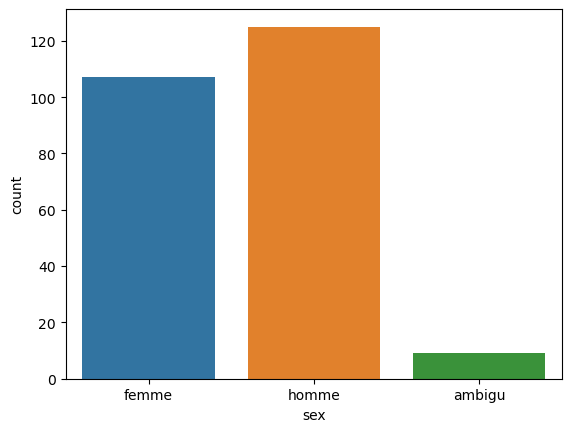

In [3]:
import seaborn as sns
%matplotlib inline

sns.countplot(transcriptions_data,x= 'sex')


Il y a 125 hommes, 107 femmes et 7 personnes que les annotateurs n'ont pas pu classifier avec les données du recensement.

Pour se faire une première idée des données, on peut représenter pour nos trois catégories les prénoms les plus fréquents, sous la forme d'un wordcloud.

C:\Users\leopo\AppData\Local\Temp\ipykernel_23816\1583295357.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


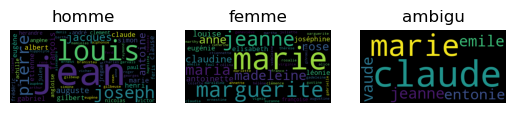

In [4]:
from wordcloud import WordCloud
# Display one wordcloud for each of the most frequent classes

from wordcloud import WordCloud
STOPWORDS = [x.strip() for x in open('data/stop_words.txt').readlines()]
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3)

transcriptions_data['firstname'].str.cat(sep=' ')

# plot a word cloud for each category
for i,cat in enumerate(['homme', 'femme',  'ambigu']):
    total_text = transcriptions_data[transcriptions_data["sex"]==cat].firstname.str.cat(sep=' ')

    wc = WordCloud(stopwords = STOPWORDS).generate(total_text)
    
    axs[i].imshow(wc)
    axs[i].axis('off')
    axs[i].set_title(cat)

fig.show()

On voit que les prénoms sont très genrées : 
- pour les hommes Jean, Louis, Jacques, Joseph, Jacques ressortent le plus
- pour les femmes Marie, Marguerite, Jeanne, Madeleine, Maria ressortent le plus
- pour les ambigues on a des prénoms très genrées comme Marie, Jeanne ou Claude et Emile. Par contre on a aussi des prénoms difficilement classables comme Vaude, et Entonie. On peut donc s'attendre à pourvoir réassigner le sexe de certains individus classifier en ambigu.

On peut aussi réaliser un wordcloud sur les informations de l'état civil.

C:\Users\leopo\AppData\Local\Temp\ipykernel_23816\3441377202.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


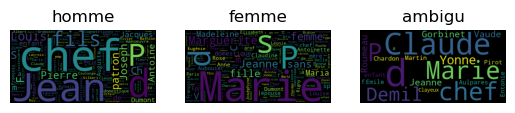

In [5]:
from wordcloud import WordCloud
# Display one wordcloud for each of the most frequent classes

from wordcloud import WordCloud
# les stop words inclut les catégorie du recensement comme lieux_naissance, nom, prénom
STOPWORDS = [x.strip() for x in open('data/stop_words.txt').readlines()]
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3)

transcriptions_data['prediction'].str.cat(sep=' ')

# plot a word cloud for each category
for i,cat in enumerate(['homme', 'femme',  'ambigu']):
    total_text = transcriptions_data[transcriptions_data["sex"]==cat].prediction.str.cat(sep=' ')

    wc = WordCloud(stopwords = STOPWORDS).generate(total_text)
    
    axs[i].imshow(wc)
    axs[i].axis('off')
    axs[i].set_title(cat)

fig.show()

On voit que au delà des prénoms genrés par catégorie, on trouve des mots clés comme chef pour les hommes ou femme pour les femmes.
On peut espérer qu'un modèle qui combine les informations de fréquence genrée de prénoms et les mots clés présents dans le recensements (soit avec un modèle simple avec une matrice de fréquence, soit avec un embedding) arrive à prédire le sexe.

### Catégorie ambigu

Les différentes personnes qui ont classées manuellement comme ambigu sont les suivantes :

In [6]:
pd.set_option('display.max_colwidth', None)

transcriptions_data[transcriptions_data["sex"]=='ambigu']

,subject_line,groundtruth,prediction,sex,firstname,male,female,ratio_homme
17,421b3e1f-ff91-4871-a8de-3af62c58e3bc,surname: Daniel firstname: Claude occupation: journalier link: chef age: 33,nom: Demil prénom: Claude date_naissance: 33 lieux_naissance: Yonne relation: chef,ambigu,claude,324134.0,4830.0,0.985318
59,8339da37-3493-4684-a9fd-090411f33d01,surname: Gorbinet firstname: Jeanne occupation: idem link: chef age: 66,nom: Gorbinet prénom: Jeanne date_naissance: 66 lieux_naissance: id relation: id,ambigu,jeanne,1765.0,1097397.0,0.001606
94,e1e6fb82-6417-4dcf-8eaa-7d5a5e9f6551,surname: Roumeau firstname: Claude occupation: cultivateur link: chef age: 30 ans,nom: Roumeau prénom: Vaude date_naissance: 1804 lieux_naissance: Aulpares relation: Chef,ambigu,vaude,0.0,0.0,0.500000
123,e6927138-689e-4d70-89c2-cf86f7171fd1,surname: Chardon firstname: Marie occupation: idem link: chef age: 84 ans,"nom: Chardon prénom: Marie date_naissance: 84 lieux_naissance: "" relation: D",ambigu,marie,10145.0,2390322.0,0.004226
124,5b244d56-e1da-4b57-934a-0a1234f34709,surname: Grillé firstname: Emile occupation: idem link: idem employer: idem age: 2,"nom: d prénom: Emile date_naissance: 2 lieux_naissance: d relation: "" profession: """,ambigu,emile,65749.0,444.0,0.993292
130,623f7836-8a46-4078-914e-f3cb9bb51c6e,surname: Martin firstname: Marie occupation: idem link: idem age: 45,nom: Martin prénom: Marie date_naissance: 47 lieux_naissance: P id état_civil: id profession: id,ambigu,marie,10145.0,2390322.0,0.004226
196,91b1d765-2195-462d-a85b-72233327ff4d,surname: Pénot firstname: Claude occupation: s.p link: enfant age: 13,nom: Pirot prénom: Claude date_naissance: 1303 lieux_naissance: id relation: enfant,ambigu,claude,324134.0,4830.0,0.985318
204,a17f5fb3-c879-4a9a-a063-e3a43f4f4a3c,surname: Coq firstname: Antonie occupation: idem link: idem employer: idem age: 16,nom: d prénom: Entonie date_naissance: 16 lieux_naissance: d relation: f,ambigu,entonie,0.0,0.0,0.500000
230,e925d46e-1ea7-4537-986e-0fe062d64fa2,surname: Clayeux firstname: Claude occupation: idem link: idem employer: idem age: 13,nom: Clayeux prénom: Claude date_naissance: 13 lieux_naissance: P relation: a,ambigu,claude,324134.0,4830.0,0.985318


On voit sur ce tableau qu'à part Vaude (en fait Claude dans Groundtruth) et Entonie (en réalité Antonie) tous les autres portent des prénoms extrêmement genrée. Il y a une division claire avec des prénoms données à  plus de 98% à des hommes, et de prénoms données à 99% à des femmes.
On va donc reclassifier la catégorie 'ambigu' avec l'information de fréquence genrée du prénom, suivant un critère simple : si les informations sont ambigus et que le prénom est porté en majorité par des hommes, on réattribue le sexe à 'homme'. Je vais donc reclassifier les différents ambigu selon la fréquence de leurs prénoms, et éjecter Vaude et Entonie.

## Modèle proposé

Comme on a pu le voir avec les nuages de mots, l'information de prénoms est déjà très genrée mais d'autres informations disponibles comme l'emploi ou  le fait d'être désigné chef ou femme sont aussi très genrées. Je propose donc de construire un modèle qui accole une représentation vectorielle du texte prédit (`prediction`) et le ratio d'apparition du prénom pour les hommes (avec 0.5 comme valeur par défaut quand le prénom ou la fréquence n'est pas disponible comme expliqué ci-dessus).

Plusieurs représentations vectorielles sont possibles, on en essayera deux :
- une approche bag-of-words en mesurant pour chaque terme le tf-idf (term frequence / document frequency) [a verif]. La matrice personne terme fréquence sera accolé aux vecteurs du ratio d'apparition du prénom pour les hommes en pop général.
- une approche par embeddings : on accolera pour chaque texte `prediction` le vecteur moyen de **Fast Text**, le vecteur de la phrase en entier généré par **Sentence-BERT** (SBERT), et le ratio d'apparition pour les hommes comme dans l'approche bag-of-word.

Dans le cas de l'approche bag-of-words, on filtrera les mots catégoriels comme "prénom:" ou "date_naissance:", car dans une approche bag-of-words, le modèle ne pourra relier un sens à ces termes, leurs fréquences d'apparition viendra juste parasiter et écraser les fréquences d'apparition des mots avec du sens comme "chef" ou "femme". La liste précise de ces termes a été mise dans `./data/stop_words.txt` et a déjà été utilisé pour créer le nuage de mots de prédiction sur la figure précédente.

Dans l'approche par embedding, on va garder au contraire ces termes car on peut espérer notamment que l'embedding de BERT soit capable de garder sémantiquement que "profession: cuisinière" contient une information genrée.

Pour chacune des matrices ainsi construite, on va construire un modèle à partir de *LinearSVC* (bibliothèque *sklearn*, encapsulation de *Liblinear*) pour ensuite prédire le sexe en fonction de la matrice.

### Préparation des données

In [7]:
from sklearn.model_selection import train_test_split

seed = 42

correction_sex_ambigu = lambda x: 'homme' if x > 0.5 else ('femme' if x < 0.5 else 'ambigu')
filter_très_ambigu = True
if filter_très_ambigu:
    # filtre out les données trop ambigu (en fréquence et en recensement) pour le modèle
    predictable_data = transcriptions_data[~((transcriptions_data["ratio_homme"]==0.5) & (transcriptions_data["sex"] == 'ambigu'))]
else:
    predictable_data = transcriptions_data.copy()
predictable_data.set_index("subject_line", inplace=True)
# reclassification du sexe des catégories ambigu avec une information de fréquence
predictable_data.loc[predictable_data["sex"] == 'ambigu', "sex"] = predictable_data.loc[predictable_data["sex"] == 'ambigu', "ratio_homme"].apply(correction_sex_ambigu)

# clean le texte des catégories pour ne pas biaiser les fréquences
STOPWORDS = [x.strip() for x in open('./data/stop_words.txt').readlines()]

X = predictable_data[["prediction","ratio_homme"]].rename(columns={
    'prediction':'text',
    'ratio_homme':'ratio'
})

Y = predictable_data.sex

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify=Y)

### Approche bag-of-word, accolée aux ratios d'apparition du prénom chez les hommes en population générale

#### Construction du modèle

In [8]:
# on met le texte en bag of words : count vectors et TfIdf
# pour l'instant pas de filtre sur les mots.

import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# Create document vectors
vectorizer = CountVectorizer(max_features=1000, stop_words=STOPWORDS) # on filtre les mots catégoriels
vectorizer.fit(X_train.text)

X_train.text_count = vectorizer.transform(X_train.text)
X_test.text_count = vectorizer.transform(X_test.text)

tf_transformer = TfidfTransformer().fit(X_train.text_count)
X_train.text_tf = tf_transformer.transform(X_train.text_count)
X_test.text_tf = tf_transformer.transform(X_test.text_count)

from scipy.sparse import hstack
X_train.combined_features = hstack([X_train.text_count, np.array(X_train['ratio']).reshape(-1,1)])
X_train.combined_features = np.nan_to_num(X_train.combined_features, nan=0.5)
X_test.combined_features = hstack([X_test.text_count, np.array(X_test['ratio']).reshape(-1,1)])
X_test.combined_features = np.nan_to_num(X_test.combined_features, nan=0.5)


from sklearn.svm import LinearSVC

model = LinearSVC()
# Train 
model.fit(X_train.combined_features,Y_train) 
# Predict
Y_pred = model.predict(X_test.combined_features)
# Evaluate 
model.score(X_test.combined_features,Y_test)

C:\Users\leopo\AppData\Local\Temp\ipykernel_23816\904968573.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_train.text_count = vectorizer.transform(X_train.text)
C:\Users\leopo\AppData\Local\Temp\ipykernel_23816\904968573.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_test.text_count = vectorizer.transform(X_test.text)
C:\Users\leopo\AppData\Local\Temp\ipykernel_23816\904968573.py:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_train.text_tf = tf_transformer.transform(X_train.text_count)
C:\Users\leopo\AppData\Local\Temp\ipykernel_23816\904968573.py:16: UserWarning: Pandas doesn't allow columns to be created via a ne

0.9791666666666666

#### Estimation de la qualité du modèle

Classification Report:
               precision    recall  f1-score   support

       femme       0.96      1.00      0.98        22
       homme       1.00      0.96      0.98        26

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



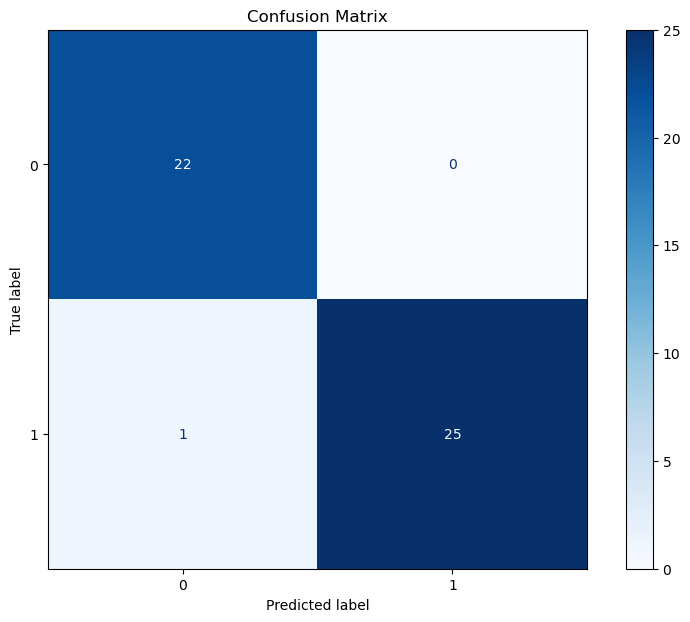

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Assuming model is your trained MultinomialNB classifier
# And X_test_tf, Y_test are your test features and labels

# Generate the classification report
report = classification_report(Y_test, Y_pred, zero_division = 0)
print("Classification Report:\n", report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
#print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix using ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

#### Cas des mal classifiés

In [10]:
import numpy as np
miss_prediction_lines = np.array(Y_test[(Y_pred!=Y_test)].index)
transcriptions_data[transcriptions_data["subject_line"].isin(miss_prediction_lines)]

,subject_line,groundtruth,prediction,sex,firstname,male,female,ratio_homme
228,5ebc6baa-2929-483a-95a0-59408e496cb1,surname: Carton firstname: Simon occupation: cultivateur link: fils age: 30,nom: Carton prénom: Simone date_naissance: 30 lieux_naissance: ed profession: Cubsinière,homme,simone,157.0,6988.0,0.021973


In [11]:
from sklearn.model_selection import cross_val_score 
from scipy.sparse import vstack

X_combined_features = vstack([X_train.combined_features,X_test.combined_features])
Y_concatenate = np.concatenate([Y_train,Y_test], axis = 0)

# Perform 5-fold cross-validation
scores = cross_val_score(model, X_combined_features, Y_concatenate, cv=5)

# Print the results
print("Cross-validated scores:", scores)
print("Average score:", np.mean(scores))

Cross-validated scores: [1.         0.97916667 1.         0.97916667 0.9787234 ]
Average score: 0.9874113475177305


c:\Users\leopo\OneDrive - GENES\NLP\nlp-lab-text-classification\.conda\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\leopo\OneDrive - GENES\NLP\nlp-lab-text-classification\.conda\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\leopo\OneDrive - GENES\NLP\nlp-lab-text-classification\.conda\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\leopo\OneDrive - GENES\NLP\nlp-lab-text-classification\.conda\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dua

### Approche embedding, accolée aux ratios d'apparition des prénoms chez les hommes

#### Construction du modèle

In [12]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import gensim.downloader as api
from gensim.models import FastText

# Load Sentence-BERT Model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Load FastText Model (this will download the model if it's not already available)
# Here, using a small model for demonstration. Consider 'fasttext-wiki-news-subwords-300' for a larger, more accurate model.
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

# Function to calculate FastText embeddings
def fasttext_embeddings(text, model):
    words = text.split()  # Simple tokenization, consider more sophisticated preprocessing
    embeddings = [model[word] for word in words if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)  # Averaging word vectors
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no words found in the model

# Compute Sentence-BERT embeddings
X_train.sbert_embeddings = np.array(X_train.text.apply(lambda x: np.array(sbert_model.encode(x))))

# Compute FastText embeddings
X_train.fasttext_embeddings = np.array(X_train.text.apply(lambda x: fasttext_embeddings(x, fasttext_model)))

# Compute Sentence-BERT embeddings
X_test.sbert_embeddings = np.array(X_test.text.apply(lambda x: sbert_model.encode(x)))

# Compute FastText embeddings
X_test.fasttext_embeddings = np.array(X_test.text.apply(lambda x: fasttext_embeddings(x, fasttext_model)))

# stack embedings with the ratio of men holding that name
import numpy as np

X_train.combined_embeddings_ratio =  np.concatenate([np.vstack(X_train.sbert_embeddings),np.vstack(X_train.fasttext_embeddings), 
np.array(X_train['ratio']).reshape(-1, 1)], axis = 1)
X_train.combined_embeddings_ratio = np.nan_to_num(X_train.combined_embeddings_ratio, nan=0.5)

X_test.combined_embeddings_ratio =  np.concatenate([np.vstack(X_test.sbert_embeddings),np.vstack(X_test.fasttext_embeddings), 
np.array(X_test['ratio']).reshape(-1, 1)], axis = 1)
X_test.combined_embeddings_ratio = np.nan_to_num(X_test.combined_embeddings_ratio, nan=0.5)

from sklearn.svm import LinearSVC

model_embeddings = LinearSVC()
# Train 
model_embeddings.fit(X_train.combined_embeddings_ratio,Y_train) 
# Predict
Y_pred = model_embeddings.predict(X_test.combined_embeddings_ratio)
# Evaluate 
model_embeddings.score(X_test.combined_embeddings_ratio,Y_test)


C:\Users\leopo\AppData\Local\Temp\ipykernel_23816\2386422011.py:23: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_train.sbert_embeddings = np.array(X_train.text.apply(lambda x: np.array(sbert_model.encode(x))))
C:\Users\leopo\AppData\Local\Temp\ipykernel_23816\2386422011.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_train.fasttext_embeddings = np.array(X_train.text.apply(lambda x: fasttext_embeddings(x, fasttext_model)))
C:\Users\leopo\AppData\Local\Temp\ipykernel_23816\2386422011.py:29: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_test.sbert_embeddings = np.array(X_test.text.apply(lambda x: sbert_model.encode(x)))
C:\Use

0.9791666666666666

#### Estimation de la qualité du modèle

Classification Report:
               precision    recall  f1-score   support

       femme       0.96      1.00      0.98        22
       homme       1.00      0.96      0.98        26

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



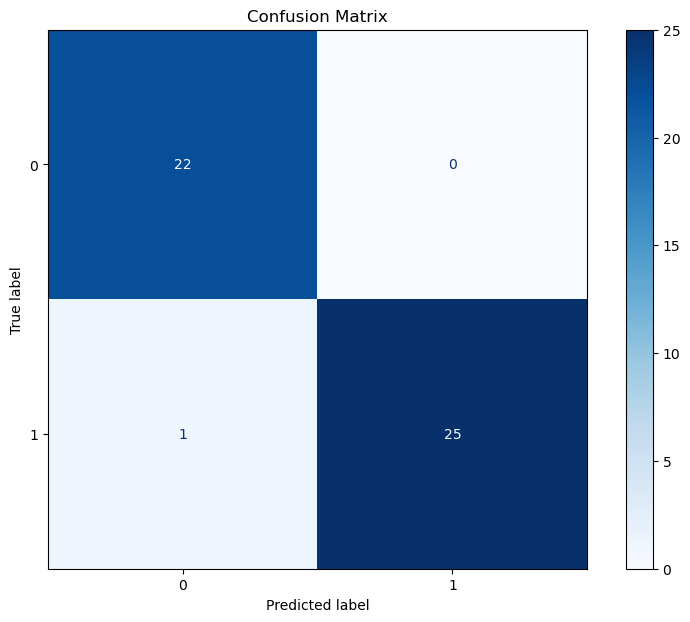

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Assuming model is your trained MultinomialNB classifier
# And X_test_tf, Y_test are your test features and labels

# Generate the classification report
report = classification_report(Y_test, Y_pred, zero_division = 0)
print("Classification Report:\n", report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
#print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix using ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

#### Cross validation

In [14]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score 
X_combined_embeddings_ratio = np.concatenate([X_train.combined_embeddings_ratio,X_test.combined_embeddings_ratio], axis = 0)
Y_concatenate = np.concatenate([Y_train,Y_test], axis = 0)

# Perform 5-fold cross-validation
scores = cross_val_score(model_embeddings, X_combined_embeddings_ratio, Y_concatenate, cv=5)

# Print the results
print("Cross-validated scores:", scores)
print("Average score:", np.mean(scores))

Cross-validated scores: [1.         0.97916667 1.         0.97916667 0.9787234 ]
Average score: 0.9874113475177305


c:\Users\leopo\OneDrive - GENES\NLP\nlp-lab-text-classification\.conda\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\leopo\OneDrive - GENES\NLP\nlp-lab-text-classification\.conda\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\leopo\OneDrive - GENES\NLP\nlp-lab-text-classification\.conda\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\leopo\OneDrive - GENES\NLP\nlp-lab-text-classification\.conda\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dua

#### Cas des mal classifiés

In [15]:
import numpy as np
miss_prediction_lines = np.array(Y_test[(Y_pred!=Y_test)].index)
transcriptions_data[transcriptions_data["subject_line"].isin(miss_prediction_lines)]

,subject_line,groundtruth,prediction,sex,firstname,male,female,ratio_homme
228,5ebc6baa-2929-483a-95a0-59408e496cb1,surname: Carton firstname: Simon occupation: cultivateur link: fils age: 30,nom: Carton prénom: Simone date_naissance: 30 lieux_naissance: ed profession: Cubsinière,homme,simone,157.0,6988.0,0.021973


## Tests avec le groundtruth pour vérifier l'effet des erreurs de transcription

### Sur le test set utilisé précédemment

C:\Users\leopo\AppData\Local\Temp\ipykernel_23816\1639855720.py:61: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_train.text_count = vectorizer.transform(X_train.text)
C:\Users\leopo\AppData\Local\Temp\ipykernel_23816\1639855720.py:62: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_test.text_count = vectorizer.transform(X_test.text)
C:\Users\leopo\AppData\Local\Temp\ipykernel_23816\1639855720.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_train.text_tf = tf_transformer.transform(X_train.text_count)
C:\Users\leopo\AppData\Local\Temp\ipykernel_23816\1639855720.py:65: UserWarning: Pandas doesn't allow columns to be created via 

Classification Report:
               precision    recall  f1-score   support

       femme       1.00      1.00      1.00        23
       homme       1.00      1.00      1.00        26

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49



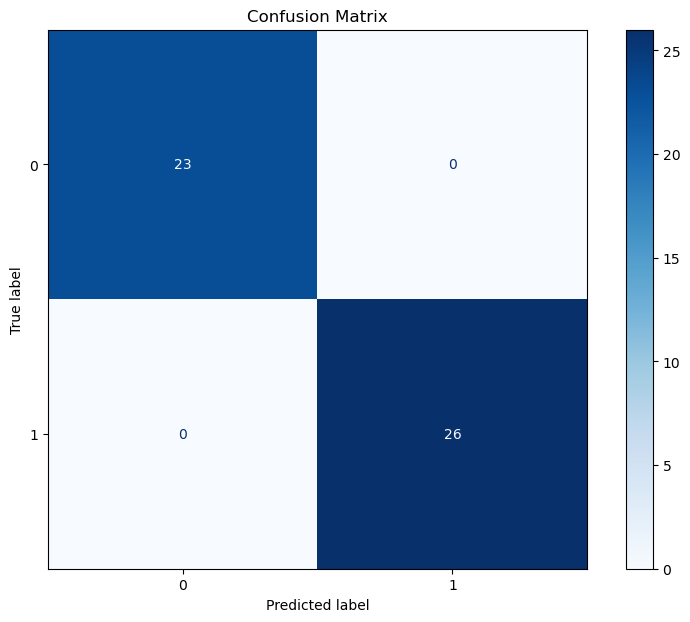

In [16]:
import pandas as pd
import re

# Charger les données
firstname_data = pd.read_csv('./data/firstname_with_sex.csv', sep=";")
transcriptions_data = pd.read_csv('./data/transcriptions_with_sex.csv',)

# Prétraitement : extraire prénoms et les normaliser (minuscule)
firstname_data['firstname'] = firstname_data['firstname'].str.lower().str.strip()
firstname_data.set_index("firstname", inplace=True)
transcriptions_data['firstname'] = transcriptions_data['groundtruth'].apply(lambda x: extract_firstname(x,keyword = r"firstname:")).str.lower().str.strip()

# proxy the missing names frequency
# we count the frequency in the provided dataset
firstname_counts_transcriptions = transcriptions_data.groupby("firstname")['sex'].value_counts().reset_index().pivot(index="firstname",columns="sex", values = "count").drop(columns = "ambigu").rename(columns={'homme':'male','femme':'female'}).fillna(0).reset_index()
# we keep only name that are not already in our firstname_data
firstname_counts_transcriptions_not_in_firstname_data = firstname_counts_transcriptions[~(firstname_counts_transcriptions["firstname"].isin(firstname_data.index))]
firstname_counts_transcriptions_not_in_firstname_data.set_index('firstname',inplace=True)
# we merge both data set
completed_firstname_data = pd.concat([firstname_data, firstname_counts_transcriptions_not_in_firstname_data], axis=0)

# we had frequency information as additionnal information of every subject
transcriptions_data = transcriptions_data.join(completed_firstname_data, on="firstname",how="left", validate="many_to_one")

transcriptions_data["ratio_homme"] = transcriptions_data["male"] / (transcriptions_data["female"]+transcriptions_data["male"])
# pour ceux dont on a quand même pas l'information (les ambigu qui ne sont pas présent dans firstname_data), on prend comme ratio un ratio neutre de 0.5
transcriptions_data["ratio_homme"].fillna(0.5,inplace=True)

from sklearn.model_selection import train_test_split

seed = 42

correction_sex_ambigu = lambda x: 'homme' if x > 0.5 else ('femme' if x < 0.5 else 'ambigu')
filter_très_ambigu = True
if filter_très_ambigu:
    # filtre out les données trop ambigu (en fréquence et en recensement) pour le modèle
    predictable_data = transcriptions_data[~((transcriptions_data["ratio_homme"]==0.5) & (transcriptions_data["sex"] == 'ambigu'))]
else:
    predictable_data = transcriptions_data.copy()
predictable_data.set_index("subject_line", inplace=True)
# reclassification du sexe des catégories ambigu avec une information de fréquence
predictable_data.loc[predictable_data["sex"] == 'ambigu', "sex"] = predictable_data.loc[predictable_data["sex"] == 'ambigu', "ratio_homme"].apply(correction_sex_ambigu)

# clean le texte des catégories pour ne pas biaiser les fréquences
STOPWORDS = [x.strip() for x in open('./data/stop_words.txt').readlines()]

X = predictable_data[["groundtruth","ratio_homme"]].rename(columns={
    'groundtruth':'text',
    'ratio_homme':'ratio'
})

Y = predictable_data.sex

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify=Y)

# on met le texte en bag of words : count vectors et TfIdf
# pour l'instant pas de filtre sur les mots.

import numpy as np

X_train.text_count = vectorizer.transform(X_train.text)
X_test.text_count = vectorizer.transform(X_test.text)

X_train.text_tf = tf_transformer.transform(X_train.text_count)
X_test.text_tf = tf_transformer.transform(X_test.text_count)

from scipy.sparse import hstack
X_train.combined_features = hstack([X_train.text_count, np.array(X_train['ratio']).reshape(-1,1)])
X_train.combined_features = np.nan_to_num(X_train.combined_features, nan=0.5)
X_test.combined_features = hstack([X_test.text_count, np.array(X_test['ratio']).reshape(-1,1)])
X_test.combined_features = np.nan_to_num(X_test.combined_features, nan=0.5)

Y_pred = model.predict(X_test.combined_features)
# Evaluate 
model.score(X_test.combined_features,Y_test)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Assuming model is your trained MultinomialNB classifier
# And X_test_tf, Y_test are your test features and labels

# Generate the classification report
report = classification_report(Y_test, Y_pred, zero_division = 0)
print("Classification Report:\n", report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
#print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix using ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

### Qualité de la prédiction sur le train set avec la groundtruth


Classification Report:
               precision    recall  f1-score   support

       femme       0.99      1.00      0.99        88
       homme       1.00      0.99      1.00       104

    accuracy                           0.99       192
   macro avg       0.99      1.00      0.99       192
weighted avg       0.99      0.99      0.99       192



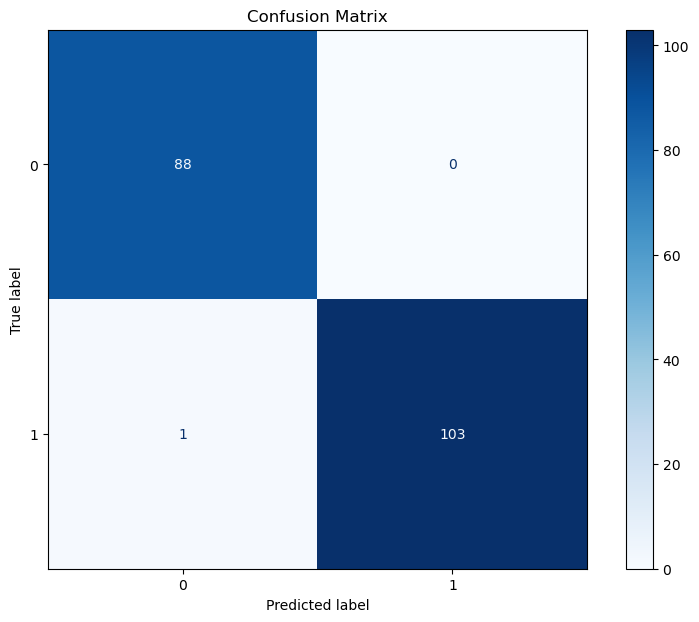

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_train = model.predict(X_train.combined_features)

# Assuming model is your trained MultinomialNB classifier
# And X_test_tf, Y_test are your test features and labels

# Generate the classification report
report = classification_report(Y_train, y_pred_train, zero_division = 0)
print("Classification Report:\n", report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_train, y_pred_train)
#print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix using ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

In [18]:
import numpy as np
miss_prediction_lines = np.array(Y_train[(y_pred_train!=Y_train)].index)
transcriptions_data[transcriptions_data["subject_line"].isin(miss_prediction_lines)]

,subject_line,groundtruth,prediction,sex,firstname,male,female,ratio_homme
146,dd12aff8-f642-4236-9050-f9bdc00783d6,surname: Tessin firstname: Marie occupation: cultivatrice link: domestique employer: Lavocat birth_date: 1891 lob: Coulanges,nom: Pesin prénom: Marie date_naissance: 1891 lieux_naissance: Coulonges relation: cullinière profession: Lameau,homme,marie,10145.0,2390322.0,0.004226


Ici encore on peut douter de l'annotation du sexe car Marie, cultivatrice, employée comme domestique parait être difficilement un homme...